In [2]:
import pickle
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.cluster import KMeans
import re
from sklearn.decomposition import PCA
from collections import *


file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_breath1.obj", "rb")
trials_breath = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\static_data.obj", "rb")
static_data = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_raw1.obj", "rb")
trials_raw = pickle.load(file)
metadata = pd.read_csv(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\d2k project metadata.csv")
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_ecg1.obj", "rb")
trials_ecg = pickle.load(file)

In [6]:
trials_breath["M21488"]["breath"]

,Unnamed: 0,Mouse_And_Session_ID,Man_Condition,Breath Number,Timestamp_Inspiration,Timestamp_Expiration,Inspiratory_Duration,Irreg_Score_Inspiratory_Duration,Expiratory_Duration,Irreg_Score_Expiratory_Duration,...,Analysis_Parameter_TTwin,Analysis_Parameter_per500win,Analysis_Parameter_maxPer500,Analysis_Parameter_maxDVTV,Analysis_Parameter_minApSec,Analysis_Parameter_minApsTT,Analysis_Parameter_minAplTT,Analysis_Parameter_SIGHwin,Analysis_Parameter_SmoothFilt,trial_no
0,0,M21488,full_recording,18621,18.621,19.060,0.439,0.000000,0.543,0.000000,...,7,201,1.0,100,0.5,2,2,11,y,0
1,1,M21488,full_recording,19603,19.603,20.116,0.513,0.168565,0.551,0.014733,...,7,201,1.0,100,0.5,2,2,11,y,0
2,2,M21488,full_recording,20667,20.667,21.140,0.473,0.077973,0.547,0.007260,...,7,201,1.0,100,0.5,2,2,11,y,0
3,3,M21488,full_recording,21687,21.687,22.136,0.449,0.050740,0.522,0.045704,...,7,201,1.0,100,0.5,2,2,11,y,0
4,4,M21488,full_recording,22658,22.658,23.160,0.502,0.118040,0.450,0.137931,...,7,201,1.0,100,0.5,2,2,11,y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,11875,M21488,full_recording,4452066,4452.066,4453.686,1.620,0.131285,0.476,0.020576,...,7,201,1.0,100,0.5,2,2,11,y,8
11876,11876,M21488,full_recording,4454162,4454.162,4455.297,1.135,0.299383,0.393,0.174370,...,7,201,1.0,100,0.5,2,2,11,y,8
11877,11877,M21488,full_recording,4455690,4455.690,4456.841,1.151,0.014097,1.606,3.086514,...,7,201,1.0,100,0.5,2,2,11,y,8
11878,11878,M21488,full_recording,4458447,4458.447,4458.634,0.187,0.837533,0.337,0.790162,...,7,201,1.0,100,0.5,2,2,11,y,8


In [4]:

def compute_timestamps(metadata, mouse_id, phase, phase2 = None, phase3 = None, phase4 = None):
    """
    Given the phase and metadata, this function returns all the timestamps in which
    the given phase occurs in seconds
    """
        
    timestamps_in_hms = list(metadata[((metadata["Comment"] == phase) | (metadata["Comment"] == phase2) | (metadata["Comment"] == phase3) | (metadata["Comment"] == phase4)) & (metadata["source file"] == mouse_id)]["Time"])
    timestamps_in_s = []
    for timestamp in timestamps_in_hms:
        processed_timestamp = re.split(':', timestamp)
        timestamp = [float(i) for i in processed_timestamp]
        
        if len(timestamp) == 2:
            timestamps_in_s.append(60*timestamp[0]+timestamp[1])
        elif len(timestamp) == 3:
            timestamps_in_s.append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])

    sorted_timestamps = sorted(timestamps_in_s)

    return sorted_timestamps

def retrieve_phase(meta_data, raw_data, static_data, trial_data,data_type,label1, label2 = None, label3 = None, label4 = None, trial_onset_first = bool, otherlabel = None):
    """
    Inputs: \n
    1) meta_data (required): metadata \n
    2) raw_data (required):  raw_data \n
    3) static_data (required) \n
    4) trial_data (required): either trials_ecg, trials_breath \n
    5) data_type (required): either "ECG" or "Breathing_flow_signal" \n
    6) trial_onset_first (required): specify whether the desired phase starts or ends with trial onset or not \n
    7) label1, label2,.. label4 (optional) (default=None): string representing desired phase timestamp, has multiple options in case the same phase was referenced in different ways in the metadata \n
    8) other_label (optional) (default=None): specify other end of phase if it's not a trial onset (e.g. looking for interval from apnea start to recovery
                 as opposed to looking for phase HR to next trial onset or looking for phase trial onset to apnea start) \n
    
    Outputs: \n
    1) interval_information_df - dataframe on mouse ID and experimental type information encoded as natural numbers for plotting purposes \n
    2) min_interval_length - minimum length of all the phases extracted in this function \n
    3) phase_interval_per_mouse - function mapping each mouse to a mapping from a number to its corresponding phase
                               (i.e 3 phase means 1:phase1, 2:phase2,3:phase3) where each
                                phase is a dataframe \n
    Method: \n
    Upon specificying the desired phase boundaries (HR recovery to trial onset/ trial onset to apnea/ eupnea recovery to trial onset ..etc) \n
    this function returns the desired phases as a dataframe in the format specified above. This function defaults to finding the phases that either \n
    start or ends with trial onset unless other_label is specified in which case other_label offsets that defualt setting in case a start/end \n
    different from trial onset is desired.
    """
    
    mice = list(trial_data.keys())
    phase_interval_per_mouse = defaultdict(lambda : defaultdict(int))
    min_interval_length = float("inf")

    phase_interval_number = []
    mouse_IDs = []
    mouse_ID_no = []
    mouse_type = []
    mouse_type_no = []
    mouse_genotypes = {}

    #
    i = 0
    for mouse_line in static_data["Line"].unique():
        for exp_type in static_data["Genotype"].unique():
            i += 1
            mouse_genotypes[mouse_line + " " + exp_type] = i
    j = 0
    #going through all the mice to extract the desired phases from each of their experiments
    for mouse in mice:
        j += 1
        print("Currently retrieving interval information for mouse {0}. Progress: {1}%" .format(mouse,100*((mice.index(mouse) + 1)/len(mice))))

        #different method for extracting the desired phase start/end timstamps depending on whether phase starts/ends with a trial onset
        if otherlabel:
            other_phase_timestamps = []
            other_phase_timestamps = compute_timestamps(meta_data,str(mouse), phase=otherlabel)
        else:
            trials_survived = int(raw_data[str(mouse)]["raw"]["trial_no"].unique()[-1]) - 1
            other_phase_timestamps = []
            for trial in range(2,trials_survived+1):
                timestamp_now = int(compute_timestamps(meta_data,str(mouse),str(trial))[0])
                if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                    other_phase_timestamps.append(timestamp_now)

        #compute timestamps for other end of inteval
        phase_onset_timestamps = compute_timestamps(meta_data,str(mouse), phase=label1, phase2 = label2, phase3= label3, phase4= label4)
        
        #even out timestamps list in case this mouse has not completed a full iteration of desired phase
        if len(phase_onset_timestamps) > len(other_phase_timestamps):
            del(phase_onset_timestamps[-1])
        elif len(phase_onset_timestamps) < len(other_phase_timestamps):
            del(other_phase_timestamps[-1])

        #removing timestamp if it's out of range of the data we're given. This is due to error in metadata/data provided
        for timestamp in phase_onset_timestamps:
            if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                phase_onset_timestamps.remove(timestamp)       
        if otherlabel:
            for timestamp in other_phase_timestamps:
                if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                    other_phase_timestamps.remove(timestamp)

        #extracting each phase one at a time
        for phase_interval in range(0,len(phase_onset_timestamps)):          
            #we determine how to set our interval starting and ending indices based on whether the desired phase starts or ends with trial onset
            if not trial_onset_first:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(phase_onset_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(other_phase_timestamps[phase_interval]) > 0]
            else:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(other_phase_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(phase_onset_timestamps[phase_interval]) > 0]
            
            #retrieving our desired phase start and ending index
            current_interval_start_timestamp = current_interval_start["Timestamp"].iloc[0]
            current_interval_end_timestamp = current_interval_end["Timestamp"].iloc[0]

            start_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_start_timestamp][0]
            end_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_end_timestamp][0]

            #find current interval and include it in phase_interval_per_mouse
            current_interval = raw_data[str(mouse)]["raw"][str(data_type)][start_index:end_index].reset_index()
            phase_interval_per_mouse[mouse][phase_interval] = current_interval
            
            #finding minium_interval_length
            if len(current_interval) < min_interval_length:
                min_interval_length = len(current_interval)

            if min_interval_length == 0:
                
                raise ValueError("{}, {}, mouse:{}" .format(other_phase_timestamps, phase_onset_timestamps, mouse))
            #collect information to create interval_information_df
            mouse_ID_no.append(j)
            mouse_IDs.append(mouse)
            phase_interval_number.append(phase_interval + 1)
            genotype = static_data[static_data["MUID"] == str(mouse)]["Line"].item() + " " + static_data[static_data["MUID"] == str(mouse)]["Genotype"].item()
            mouse_type.append(genotype)
            mouse_type_no.append(mouse_genotypes[genotype])

    #creating inverval_information_df 
    interval_information_df = pd.DataFrame(list(zip(mouse_ID_no,mouse_IDs, phase_interval_number, mouse_type, mouse_type_no)), columns = ["Mouse ID #","Mouse ID", "Recovery interval #", "Mouse Type", "Mouse Type #"])

    return interval_information_df, min_interval_length, phase_interval_per_mouse


In [8]:
def compute_timestamps(metadata, mouse_id, all = False, breath_only = False, phase = None, phase2 = None, phase3 = None, phase4 = None):
    """
    Given the required phase(s) and metadata, this function returns all the timestamps in which
    the given phase occurs in seconds as a list \n  

    Inputs:
    1) metadata
    2) mouse_id
    3) all - (default: False) boolean indicating whether all timestamps in experiments are requested as opposed to a select few
    4) breath_only - (default: False) Only if all == True. Excludes all HR Recovery timestamps when set to true
    5) phase, phase2, ... - all phases requested. At least 1 and at most 5 phases.

    if all == True, all timestamps in the experiment is returned \n
    Output formatted as follows: \n
        timestamps_in_s["trial"] = [list of timestamps] \n
        timestamps_in_s["other"]["timestamp"] = [all timestamps for non-trial onset] \n
        timestamps_in_s["other"]["comment"] = [names of all timestamps for not-trial onset]  \n
    if all == false, only specified timestamps are returned \n
    Output is just a 
    """
        
    if not all:
        #retreiving all relevant timestamps
        timestamps_in_hms = list(metadata[((metadata["Comment"] == phase) | (metadata["Comment"] == phase2) | (metadata["Comment"] == phase3) | (metadata["Comment"] == phase4)) & (metadata["source file"] == mouse_id)]["Time"])
        timestamps_in_s = []
        
        #converting timstamps from h:m:s to seconds
        for timestamp in timestamps_in_hms:
            processed_timestamp = re.split(':', timestamp)
            timestamp = [float(i) for i in processed_timestamp]   
            if len(timestamp) == 1:
                timestamps_in_s.append(timestamp[0])
            elif len(timestamp) == 2:
                timestamps_in_s.append(60*timestamp[0]+timestamp[1])
            elif len(timestamp) == 3:
                timestamps_in_s.append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])

        return timestamps_in_s

    else: #retreive all timestamps in experiment
        comments = list(metadata[metadata["source file"] == mouse_id]["Comment"]) 
        timestamps_in_hms = list(metadata[metadata["source file"] == mouse_id]["Time"]) 
        timestamps_in_s = defaultdict(lambda: defaultdict(str))

        if breath_only:  #exclude HR recovery timestamps
            other_comments = []
            other_timestamps = []
            for timestamp in range(0,len(comments)):
                if comments[timestamp] not in ["HR recovery","Hr recovery","HR recovery - No signal", "hr recovery"]:
                    other_comments.append(comments[timestamp])
                    other_timestamps.append(timestamps_in_hms[timestamp])
            timestamps_in_hms = other_timestamps
            comments = other_comments

        timestamps_in_s["trial"] = []
        timestamps_in_s["other"]["timestamp"] = []
        timestamps_in_s["other"]["comment"] = []

        #converting all hms timestamps 
        for stage in range(0,len(comments)):
            if comments[stage].isdecimal(): #if timestamps is trial onset, it is assigned elsewehere
                processed_timestamp = re.split(':', timestamps_in_hms[stage])
                timestamp = [float(i) for i in processed_timestamp]   
                if len(timestamp) == 1:
                    timestamps_in_s["trial"].append(timestamp[0])
                    timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                elif len(timestamp) == 2:
                    timestamps_in_s["trial"].append(60*timestamp[0]+timestamp[1])
                    timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                elif len(timestamp) == 3:
                    timestamps_in_s["trial"].append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])
                    timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                timestamps_in_s["other"]["comment"].append(comments[stage])
            else:
                if not comments[stage][1:].isdecimal():
                    processed_timestamp = re.split(':', timestamps_in_hms[stage])
                    timestamp = [float(i) for i in processed_timestamp]   
                    if len(timestamp) == 1:
                        timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                    elif len(timestamp) == 2:
                        timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                    elif len(timestamp) == 3:
                        timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                    timestamps_in_s["other"]["comment"].append(comments[stage])

        return timestamps_in_s

def retrieve_phase(meta_data, raw_data, static_data, trial_data,data_type,label1, label2 = None, label3 = None, label4 = None, trial_onset_first = bool, otherlabel = None, otherlabel2 = None):
    """
    Inputs: \n
    1) meta_data (required): metadata \n
    2) raw_data (required):  raw_data \n
    3) static_data (required) \n
    4) trial_data (required): either trials_ecg, trials_breath \n
    5) data_type (required): either "ECG" or "Breathing_flow_signal" \n
    6) trial_onset_first (required): specify whether the desired phase starts or ends with trial onset or not. Set to False if other_label is phase onset \n
    7) label1, label2,.. label4 (optional) (default=None): string representing desired phase timestamp, has multiple options in case the same phase was referenced in different ways in the metadata \n
    8) other_label (optional) (default=None): specify other end of phase if it's not a trial onset (e.g. looking for interval from apnea start to recovery
                 as opposed to looking for phase HR to next trial onset or looking for phase trial onset to apnea start) \n
    
    Outputs: \n
    1) interval_information_df - dataframe on mouse ID and experimental type information encoded as natural numbers for plotting purposes \n
    2) min_interval_length - minimum length of all the phases extracted in this function \n
    3) phase_interval_per_mouse - function mapping each mouse to a mapping from a number to its corresponding phase
                               (i.e 3 phase means 1:phase1, 2:phase2,3:phase3) where each
                                phase is a dataframe \n
    Method: \n
    Upon specificying the desired phase boundaries (HR recovery to trial onset/ trial onset to apnea/ eupnea recovery to trial onset ..etc) \n
    this function returns the desired phases as a dataframe in the format specified above. This function defaults to finding the phases that either \n
    start or ends with trial onset unless other_label is specified in which case other_label offsets that defualt setting in case a start/end \n
    different from trial onset is desired.
    """
    
    mice = list(trial_data.keys())
    phase_interval_per_mouse = defaultdict(lambda : defaultdict(int))
    min_interval_length = float("inf")

    phase_interval_number = []
    mouse_IDs = []
    mouse_ID_no = []
    mouse_type = []
    mouse_type_no = []
    mouse_genotypes = {}
    
    #
    i = 0
    for mouse_line in static_data["Line"].unique():
        for exp_type in static_data["Genotype"].unique():
            i += 1
            mouse_genotypes[mouse_line + " " + exp_type] = i
    j = 0
    #going through all the mice to extract the desired phases from each of their experiments
    for mouse in mice:
        j += 1
        print("Currently retrieving interval information for mouse {0}. Progress: {1}%" .format(mouse,100*((mice.index(mouse) + 1)/len(mice))))

        #different method for extracting the desired phase start/end timstamps depending on whether phase starts/ends with a trial onset
        if otherlabel:
            other_phase_timestamps = []
            other_phase_timestamps = compute_timestamps(meta_data,str(mouse), all=False, phase=otherlabel, phase2=otherlabel2)
        else:
            trials_survived = int(raw_data[str(mouse)]["raw"]["trial_no"].unique()[-1])
            other_phase_timestamps = []
            if trial_onset_first:
                for trial in range(1,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)
            else:
                for trial in range(2,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)

        #compute timestamps for other end of inteval
        phase_onset_timestamps = compute_timestamps(meta_data,str(mouse), phase=label1, phase2 = label2, phase3= label3, phase4= label4)
        
        #even out timestamps list in case this mouse has not completed a full iteration of desired phase
        if len(phase_onset_timestamps) > len(other_phase_timestamps):
            del(phase_onset_timestamps[-1])
        elif len(phase_onset_timestamps) < len(other_phase_timestamps):
            del(other_phase_timestamps[-1])

        #removing timestamp if it's out of range of the data we're given. This is due to error in metadata/data provided
        for timestamp in phase_onset_timestamps:
            if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                phase_onset_timestamps.remove(timestamp)       
        if otherlabel:
            for timestamp in other_phase_timestamps:
                if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                    other_phase_timestamps.remove(timestamp)

        #extracting each phase one at a time
        for phase_interval in range(0,len(phase_onset_timestamps)):          
            #we determine how to set our interval starting and ending indices based on whether the desired phase starts or ends with trial onset
            if not trial_onset_first:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(phase_onset_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(other_phase_timestamps[phase_interval]) > 0]
            else:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(other_phase_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(phase_onset_timestamps[phase_interval]) > 0]
            
            #retrieving our desired phase start and ending index
            current_interval_start_timestamp = current_interval_start["Timestamp"].iloc[0]
            current_interval_end_timestamp = current_interval_end["Timestamp"].iloc[0]

            start_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_start_timestamp][0]
            end_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_end_timestamp][0]
        
            #find current interval and include it in phase_interval_per_mouse
            if (start_index < len(raw_data[str(mouse)]["raw"][str(data_type)])) & (end_index < len(raw_data[str(mouse)]["raw"][str(data_type)])):
                current_interval = raw_data[str(mouse)]["raw"][str(data_type)][start_index:end_index].reset_index()
                phase_interval_per_mouse[mouse][phase_interval] = current_interval
            
            #finding minium_interval_length
            if len(current_interval) < min_interval_length:
                min_interval_length = len(current_interval)

            if min_interval_length == 0:
                raise ValueError("{}, {}, mouse:{}, start: {}, end: {}, total length: {}" .format(other_phase_timestamps, phase_onset_timestamps, mouse, start_index, end_index, 
                                                                                            len(raw_data[str(mouse)]["raw"][str(data_type)])))

            #collect information to create interval_information_df
            mouse_ID_no.append(j)
            mouse_IDs.append(mouse)
            phase_interval_number.append(phase_interval + 1)
            genotype = static_data[static_data["MUID"] == str(mouse)]["Line"].item() + " " + static_data[static_data["MUID"] == str(mouse)]["Genotype"].item()
            mouse_type.append(genotype)
            mouse_type_no.append(mouse_genotypes[genotype])

    #creating inverval_information_df 
    interval_information_df = pd.DataFrame(list(zip(mouse_ID_no,mouse_IDs, phase_interval_number, mouse_type, mouse_type_no)), columns = ["Mouse ID #","Mouse ID", "Recovery interval #", "Mouse Type", "Mouse Type #"])

    return interval_information_df, min_interval_length, phase_interval_per_mouse


In [13]:
info_df, min_length, phase_data_df = retrieve_phase(metadata, trials_raw, static_data, trials_breath, "Breathing_flow_signal", label1= "eupnea recovery", label2="eupnea starts", trial_onset_first=False)

Currently retrieving interval information for mouse M20864. Progress: 5.0%
Currently retrieving interval information for mouse M20865. Progress: 10.0%
Currently retrieving interval information for mouse M20867. Progress: 15.0%
Currently retrieving interval information for mouse M20868. Progress: 20.0%
Currently retrieving interval information for mouse M20869. Progress: 25.0%
Currently retrieving interval information for mouse M20870. Progress: 30.0%
Currently retrieving interval information for mouse M20874. Progress: 35.0%
Currently retrieving interval information for mouse M21480. Progress: 40.0%
Currently retrieving interval information for mouse M21481. Progress: 45.0%
Currently retrieving interval information for mouse M21483. Progress: 50.0%
Currently retrieving interval information for mouse M21484. Progress: 55.00000000000001%
Currently retrieving interval information for mouse M21486. Progress: 60.0%
Currently retrieving interval information for mouse M21487. Progress: 65.0%


array(['Cal 20 Room Air', 'Pre-CNO Room Air', 'Post-CNO Room Air', '1',
       'apnea starts', 'R1', 'first gasp', 'HR recovery',
       'eupnea recovery', '2', 'R2', '3', 'R3', '4', 'R4', '5', 'R5', '6',
       'R6', '7', 'R7', '8', 'R8', 'Hr recovery', '9', 'R9', '10', 'R10',
       'eupnea starts', 'Cal 5 Room Air', 'Pre-CNo Room Air',
       'Post-CNo Room Air', 'hr recovery', '11', 'R11', '12', 'R12', '13',
       'R13', '14', 'R14', 'HR recovery - No signal', 'apea starts', '15',
       'R15'], dtype=object)

In [32]:
from scipy.signal import butter, filtfilt
def butter_lowpass(lowcutoff, highcutoff, fs, order=5):
        nyq = 0.5 * fs
        lowcutoff = lowcutoff / nyq        
        highcutoff = highcutoff / nyq
        a,b = butter(order, [lowcutoff, highcutoff], analog=False, btype='bandpass',output = 'ba')
        return a,b

def butter_bandpass_filter(data, lowcutoff, highcutoff, fs, order=5):
        a,b = butter_lowpass(lowcutoff, highcutoff, fs, order=order)
        y = filtfilt(a,b, data)
        return y

def bandpass_filter(low, high, fs,order, signal):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz


    plt.figure(figsize = (8,8))
    plt.plot(signal, label='Raw signal')
    plt.title("Unfiltered signal", size = 10)
    plt.xlabel("Time (ms)", size = 10)
    plt.ylabel("Ventflow", size = 10)

    filtered_data = butter_bandpass_filter(signal, low, high, fs, order)

    plt.figure(figsize = (8,8))
    plt.plot(filtered_data)
    plt.title("Bandpass Filtered Signal, Cutoff = {}-{} Hz" .format(low,high), size = 10)
    plt.xlabel("Time (ms)", size = 10)
    plt.ylabel("Ventflow", size = 10)

    return filtered_data
    

In [37]:
metadata[metadata["source file"] == "M21488"]

,source file,Channel,Number,Time,Comment
0,M21488,*,1,17.799,Cal 20 Room Air
1,M21488,*,2,8:44.849,Pre-CNO Room Air
2,M21488,*,3,20:00.299,Post-CNO Room Air
3,M21488,*,4,29:59.949,1
4,M21488,8,20,30:26.88,apnea starts
5,M21488,*,5,30:27.049,R1
6,M21488,8,21,30:46.05,first gasp
7,M21488,6,23,30:55.27,HR recovery
8,M21488,8,22,31:04.67,eupnea recovery
9,M21488,*,6,35:44.249,2


In [50]:
trials_raw["M21488"]["raw"][2214987:2214987+1]

,Timestamp,Breathing_flow_signal,O2_sensor_data,CO2_sensor_data,Chamber_temperature,ECG,Heart_Rate,Integrated_Flow,Breathing,trial_no
2232786,2232.801025,-0.241563,1.938438,0.146875,35.9375,0.009397,583.348816,-406.564789,-0.002609,2.0


          index       ECG
0       2541781 -0.008377
1       2541782 -0.000126
2       2541783  0.006878
3       2541784  0.006010
4       2541785 -0.000854
...         ...       ...
292994  2834775  0.019587
292995  2834776  0.027472
292996  2834777  0.008740
292997  2834778 -0.045534
292998  2834779 -0.069972

[292999 rows x 2 columns]
292999


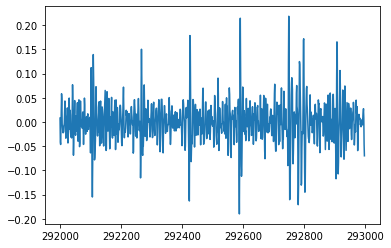

In [10]:
mouse_data = phase_data_df["M21488"][2]
print(mouse_data)
print(len(mouse_data))
start = 292000
end = 293000
ecg_minisample = mouse_data["ECG"][start:end] - np.mean(mouse_data["ECG"][start:end])

plt.plot(ecg_minisample)

In [41]:
trials_raw["M21488"]["raw"]

,Timestamp,Breathing_flow_signal,O2_sensor_data,CO2_sensor_data,Chamber_temperature,ECG,Heart_Rate,Integrated_Flow,Breathing,trial_no
17799,17.799999,-0.213125,2.090625,-0.000312,35.0000,-0.000656,NaN,-3.593165,0.000120,0.0
17800,17.801001,-0.215000,2.090313,0.000000,34.6875,0.000577,NaN,-3.593380,0.000112,0.0
17801,17.802000,-0.215312,2.090937,-0.000312,34.6875,-0.000061,NaN,-3.593594,0.000112,0.0
17802,17.802999,-0.214375,2.090937,-0.000312,34.3750,-0.000072,NaN,-3.593809,0.000103,0.0
17803,17.804001,-0.214375,2.090625,0.000000,34.6875,-0.000398,NaN,-3.594024,0.000103,0.0
...,...,...,...,...,...,...,...,...,...,...
5063696,5063.745117,-0.204063,2.086562,0.008750,34.6875,-0.005134,NaN,-972.729797,-0.169361,8.0
5063697,5063.746094,-0.201250,2.085938,0.008438,34.6875,-0.003884,NaN,-972.729980,-0.169498,8.0
5063698,5063.747070,-0.202500,2.085625,0.008750,34.3750,-0.000446,NaN,-972.730225,-0.169704,8.0
5063699,5063.748047,-0.201875,2.085625,0.009062,34.6875,-0.002634,NaN,-972.730408,-0.169979,8.0


0
[-0.281875  -0.28375   -0.2846875 ... -0.1959375 -0.1953125 -0.195625 ]
(100000,)
(100000,)
0
[-0.03267094 -0.03419422 -0.03560821 ...  0.00224537  0.00222659
  0.00224028]
100000   -0.281875
100001   -0.283750
100002   -0.284687
100003   -0.285000
100004   -0.286250
            ...   
199995   -0.196250
199996   -0.195937
199997   -0.195937
199998   -0.195312
199999   -0.195625
Name: Breathing_flow_signal, Length: 100000, dtype: float32


Text(0.5, 1.0, 'Spectrogram of the Signal, Hanning Window, NFFT = 256, 50% Overlap')

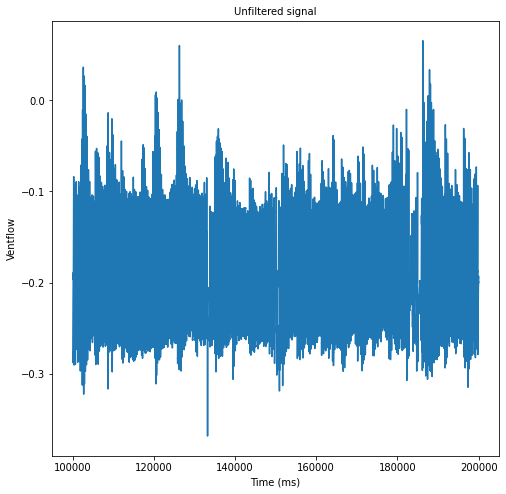

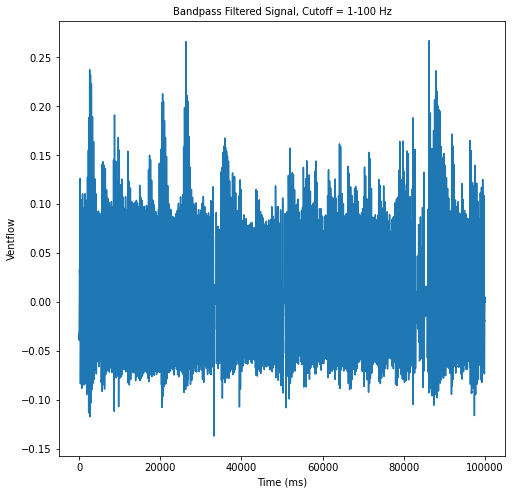

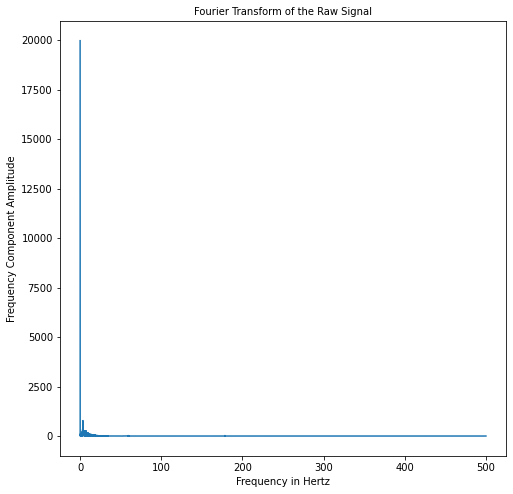

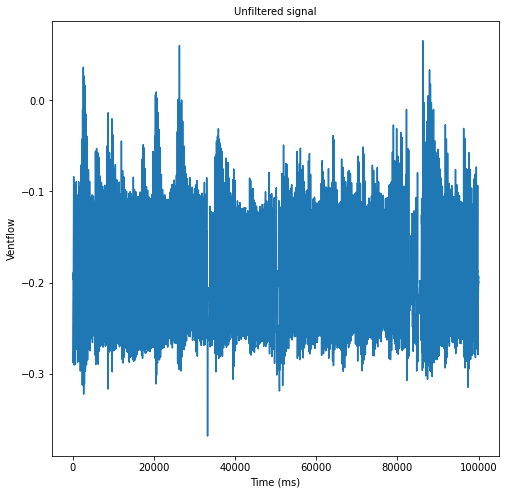

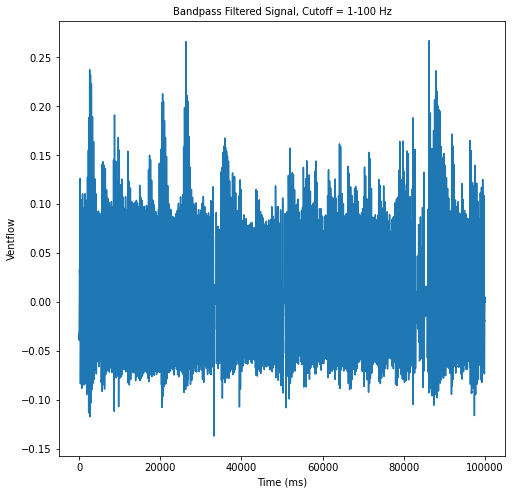

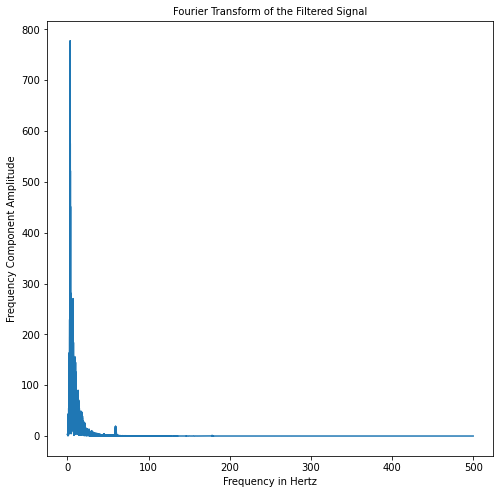

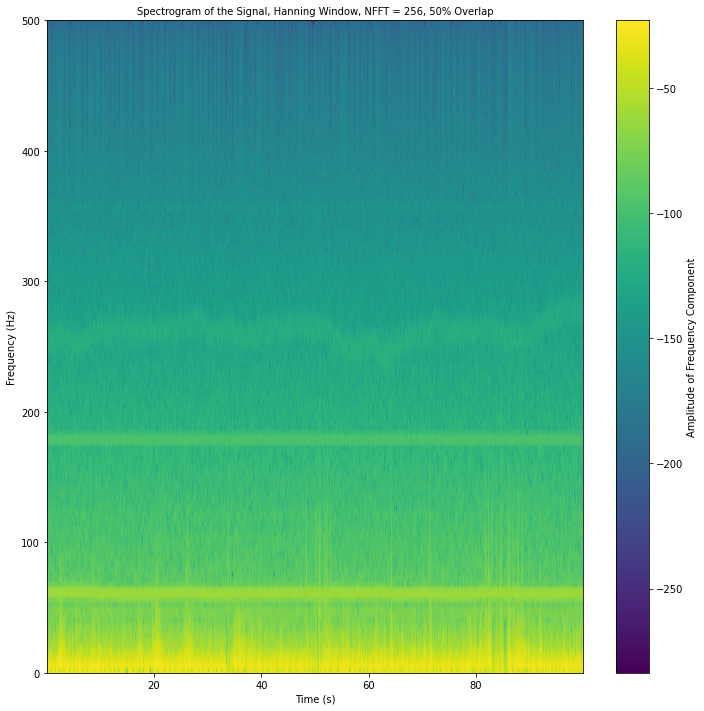

In [53]:
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt

mouse_data = phase_data_df["M21488"][2]

start = 100000
end = 200000
ecg_minisample = mouse_data["Breathing_flow_signal"][start:end]
SAMPLE_RATE = 1000
DURATION = end - start + 1
N = DURATION

print(np.sum(np.isnan(np.array(ecg_minisample))))

filtered_signal = bandpass_filter(1, 100, 1000, 2, ecg_minisample)
filtered_signal = ecg_minisample
yf = rfft(np.array(ecg_minisample))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

plt.figure(figsize = (8,8))
plt.plot(xf, np.abs(yf))
plt.xlabel('Frequency in Hertz', size= 10)
plt.ylabel("Frequency Component Amplitude", size= 10)
plt.title("Fourier Transform of the Raw Signal", size= 10)

print(np.array(ecg_minisample))
filtered_signal = bandpass_filter(1, 100, 1000, 2, np.array(ecg_minisample))

print(np.shape(filtered_signal))
print(np.shape(ecg_minisample))
print(np.sum(np.isnan(np.array(filtered_signal))))
print(filtered_signal)
print(ecg_minisample)
yf = rfft(np.array(filtered_signal))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

plt.figure(figsize = (8,8))
plt.plot(xf, np.abs(yf))
plt.xlabel('Frequency in Hertz', size= 10)
plt.ylabel("Frequency Component Amplitude", size= 10)
plt.title("Fourier Transform of the Filtered Signal", size= 10)

plt.figure(figsize = (12,12))
spectrum, freqs, t, im = plt.specgram(filtered_signal, Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
plt.xlabel("Time (s)", size = 10)
plt.ylabel("Frequency (Hz)", size = 10)
cbar = plt.colorbar()
cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)
plt.title("Spectrogram of the Signal, Hanning Window, NFFT = 256, 50% Overlap", size = 10)

In [55]:
import gc
plt.close()
gc.collect()

0

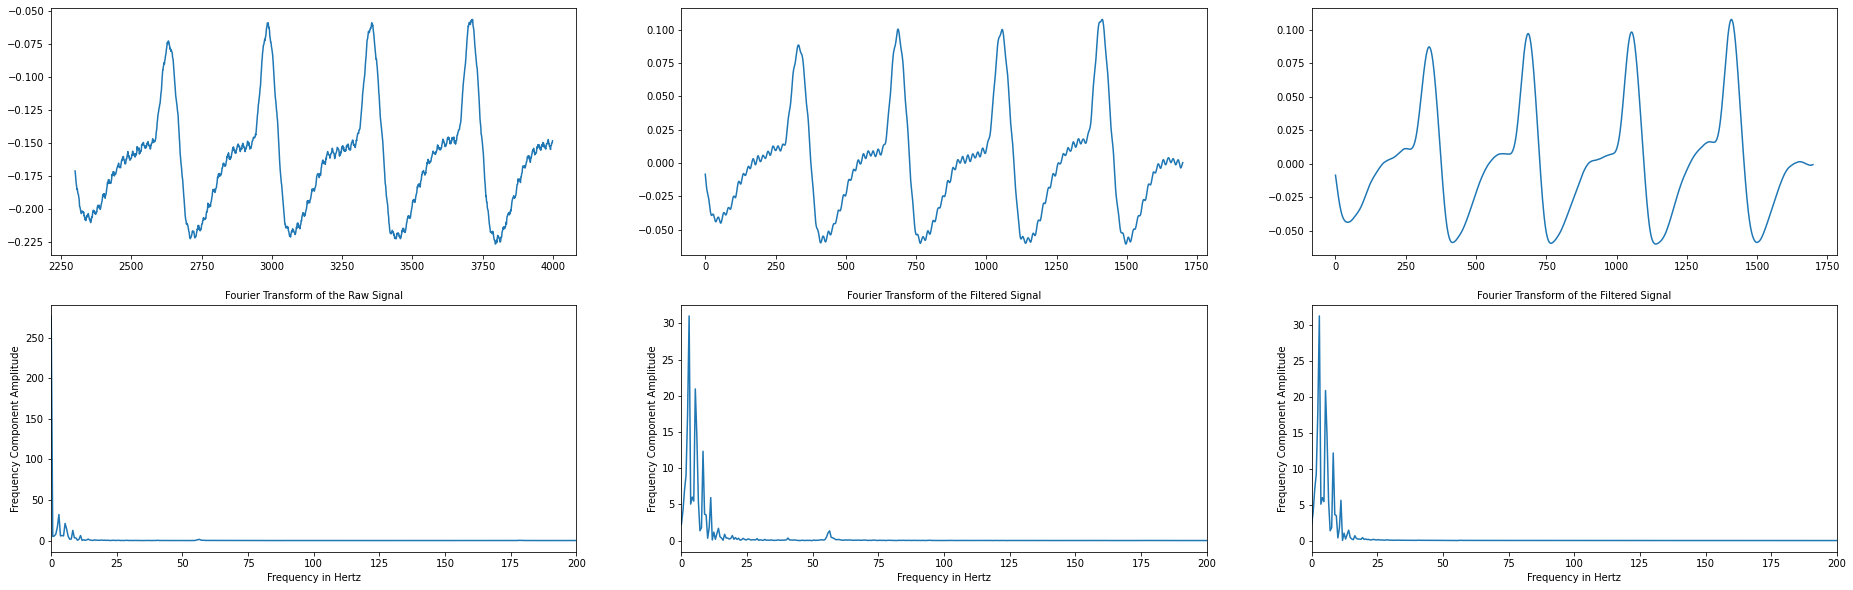

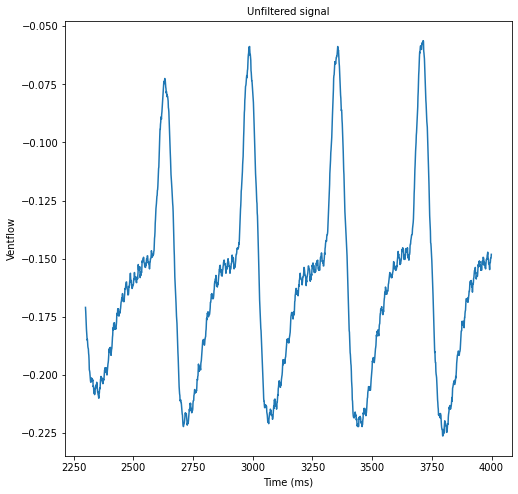

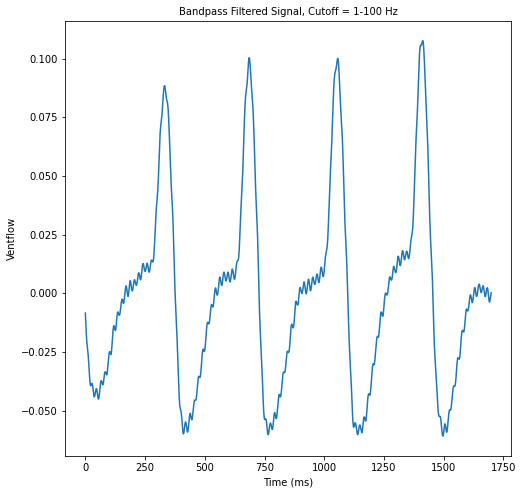

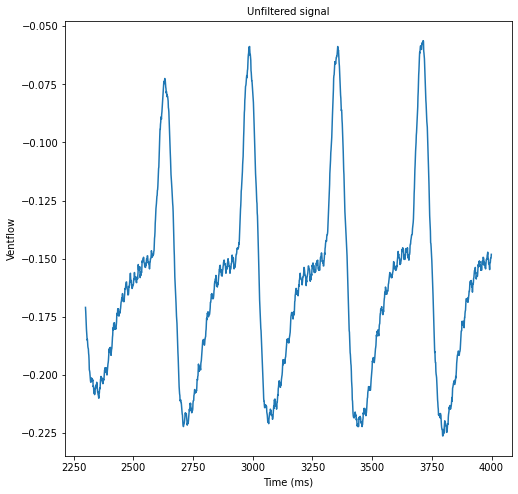

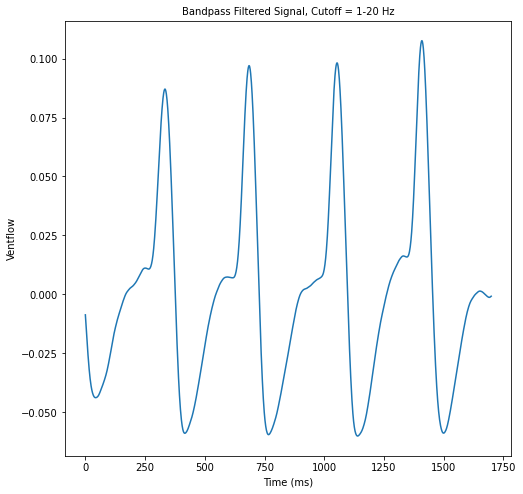

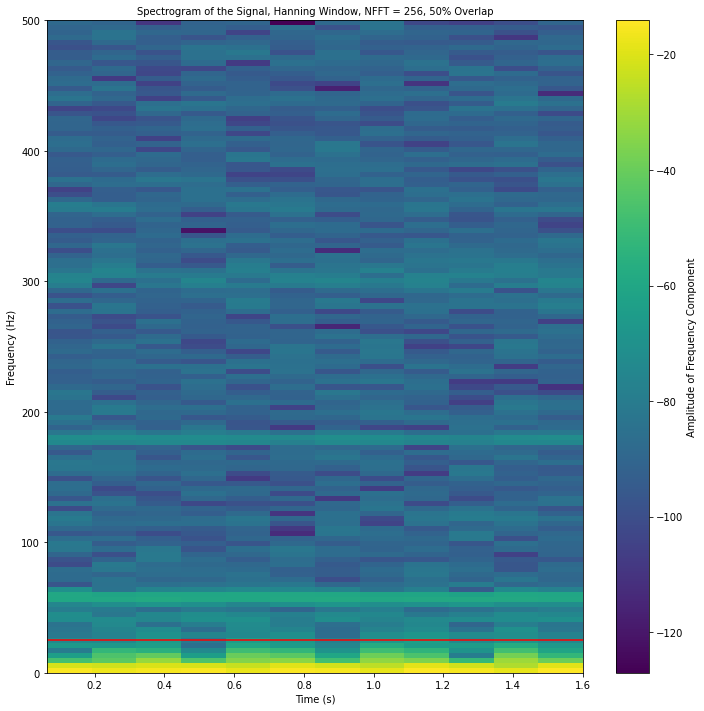

In [85]:


signal = phase_data_df["M20864"][1]["Breathing_flow_signal"][2300:4000]

fig = plt.figure(figsize = (32,10))

ax = fig.add_subplot(2,3,1)
ax.plot(phase_data_df["M20864"][1]["Breathing_flow_signal"][2300:4000])

SAMPLE_RATE = 1000
DURATION = len(signal) + 1
N = DURATION


yf = rfft(np.array(signal))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

ax = fig.add_subplot(2,3,4)
ax.plot(xf, np.abs(yf))
ax.set_xlabel('Frequency in Hz', size= 10)
ax.set_ylabel("Frequency Component Amplitude", size= 10)
ax.set_title("Fourier Transform of the Raw Signal", size= 10)
ax.set_xlim(0,200)

filtered_signal = bandpass_filter(1, 100, 1000, 2, signal)

ax = fig.add_subplot(2,3,2)
ax.plot(filtered_signal)

yf = rfft(np.array(filtered_signal))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

ax = fig.add_subplot(2,3,5)
ax.plot(xf, np.abs(yf))
ax.set_xlabel('Frequency in Hz', size= 10)
ax.set_ylabel("Frequency Component Amplitude", size= 10)
ax.set_title("Fourier Transform of the Filtered Signal", size= 10)
ax.set_xlim(0,200)

filtered_signal = bandpass_filter(1, 20, 1000, 2, signal)

ax = fig.add_subplot(2,3,3)
ax.plot(filtered_signal)

yf = rfft(np.array(filtered_signal))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

ax = fig.add_subplot(2,3,6)
ax.plot(xf, np.abs(yf))
ax.set_xlabel('Frequency in Hz', size= 10)
ax.set_ylabel("Frequency Component Amplitude", size= 10)
ax.set_title("Fourier Transform of the Filtered Signal", size= 10)
ax.set_xlim(0,200)

plt.figure(figsize = (12,12))
spectrum, freqs, t, im = plt.specgram(signal, Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
plt.xlabel("Time (s)", size = 10)
plt.ylabel("Frequency (Hz)", size = 10)
cbar = plt.colorbar()
cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)
plt.title("Spectrogram of the Signal, Hanning Window, NFFT = 256, 50% Overlap", size = 10)
plt.axhline(25, c="red")


3
1
[2140.149]
2
[2494.849]
3
[2863.5]
[2140.149]
[2494.849]
[2863.5]


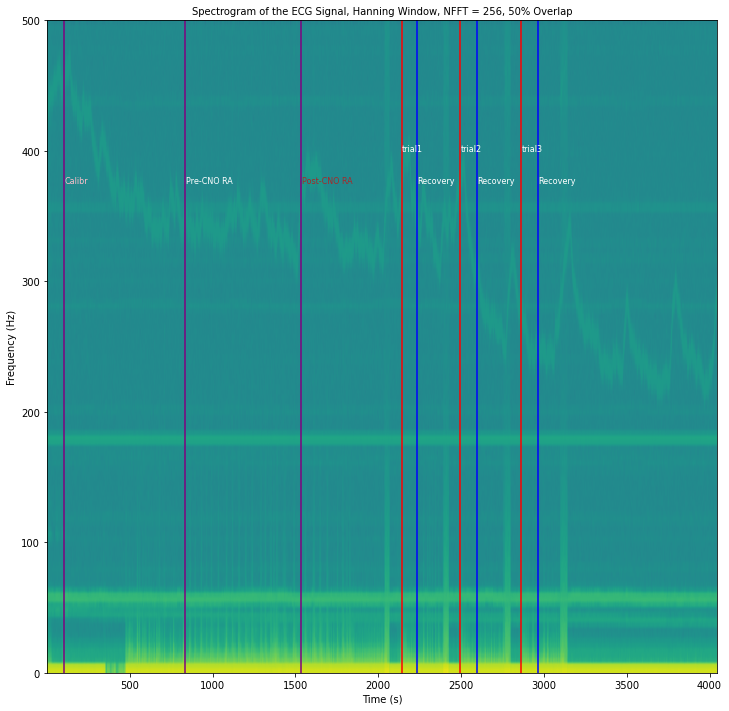

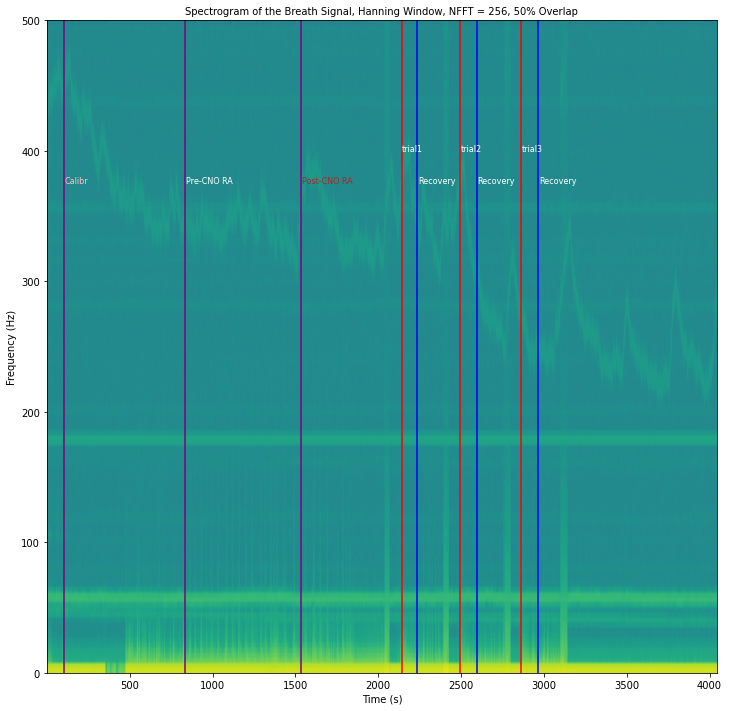

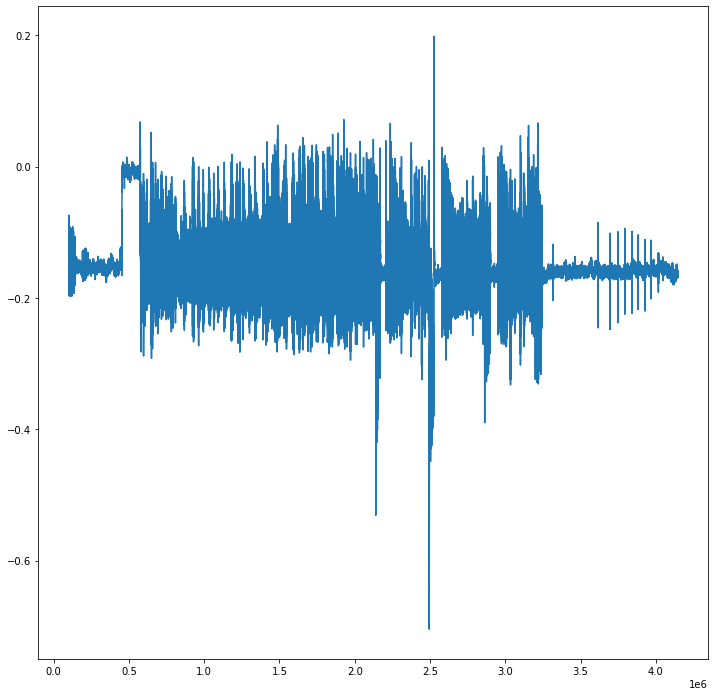

In [27]:
for mouse in ["M20864"]:
    plt.figure(figsize = (12,12))
    spectrum, freqs, t, im = plt.specgram(trials_raw[mouse]["raw"]["Breathing_flow_signal"], Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
    plt.xlabel("Time (s)", size = 10)
    plt.ylabel("Frequency (Hz)", size = 10)
    num_trials = int(list(trials_raw[mouse]["raw"]["trial_no"])[-1])
    print(num_trials)
    hr_recovery_timestamps = compute_timestamps(metadata, mouse, phase= "HR recovery", phase2="Hr recovery", phase3="HR recovery - No signal", phase4 = "hr recovery")
    for trial in range(1,num_trials + 1):
        print(trial)
        time = compute_timestamps(metadata, mouse, all=False, phase= str(trial))
        print(time)
        plt.axvline(time[0], color = "red")
        plt.text(time[0]+3,400,'trial'+str(trial), color = "white", size = 8)
    for stamp in hr_recovery_timestamps:
        plt.axvline(stamp, color = "blue")
        plt.text(stamp+3,375,"Recovery", color = "white", size = 8)
        
    #cbar = plt.colorbar()
    #cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)

    plt.title("Spectrogram of the ECG Signal, Hanning Window, NFFT = 256, 50% Overlap", size = 10)
    pre_cno = compute_timestamps(metadata, mouse,all=False,  phase="Pre-CNO Room Air",phase2="Pre-CNo Room Air")
    for stamp in pre_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Pre-CNO RA", color = "white", size = 8)
    post_cno = compute_timestamps(metadata, mouse,all=False,  phase="Post-CNO Room Air",phase2="Post-CNO Room Air")
    for stamp in post_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Post-CNO RA", color = "brown", size = 8)
    calibr = compute_timestamps(metadata, mouse,all=False,  phase="Cal 20 Room Air")
    if len(calibr) != 0:
        plt.axvline(calibr[0], color = "purple")
        plt.text(calibr[0]+3,375,"Calibr", color = "pink", size = 8)

    plt.figure(figsize = (12,12))
    spectrum, freqs, t, im = plt.specgram(trials_raw[mouse]["raw"]["Breathing_flow_signal"], Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
    plt.xlabel("Time (s)", size = 10)
    plt.ylabel("Frequency (Hz)", size = 10)
    num_trials = int(list(trials_raw[mouse]["raw"]["trial_no"])[-1])
    br_recovery_timestamps = compute_timestamps(metadata, mouse,all=False,  phase= "eupnea recovery", phase2="eupnea starts")
    for trial in range(1,num_trials + 1):
        time = compute_timestamps(metadata, mouse,all=False, phase= str(trial))
        print(time)
        plt.axvline(time[0], color = "red")
        plt.text(time[0]+3,400,'trial'+str(trial), color = "white", size = 8)
    for stamp in br_recovery_timestamps:
        plt.axvline(stamp, color = "blue")
        plt.text(stamp+3,375,"Recovery", color = "white", size = 8)
    #cbar = plt.colorbar()
    #cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)
    plt.title("Spectrogram of the Breath Signal, Hanning Window, NFFT = 256, 50% Overlap", size = 10)
    pre_cno = compute_timestamps(metadata, mouse,all=False,  phase="Pre-CNO Room Air",phase2="Pre-CNo Room Air")
    for stamp in pre_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Pre-CNO RA", color = "white", size = 8)
    post_cno = compute_timestamps(metadata, mouse, all=False, phase="Post-CNO Room Air",phase2="Post-CNO Room Air")
    for stamp in post_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Post-CNO RA", color = "brown", size = 8)
    calibr = compute_timestamps(metadata, mouse, all=False, phase="Cal 20 Room Air")
    if len(calibr) != 0:
        plt.axvline(calibr[0], color = "purple")
        plt.text(calibr[0]+3,375,"Calibr", color = "pink", size = 8)

    plt.figure(figsize = (12,12))
    """for trial in range(1,num_trials + 1):
        time = compute_timestamps(metadata, mouse, str(trial))
        plt.axvline(time[0], color = "red")
        plt.text(time[0]+3,400,'trial'+str(trial), color = "white", size = 8)"""
    plt.plot(trials_raw[mouse]["raw"]["Timestamp"]*1000,trials_raw[mouse]["raw"]["Breathing_flow_signal"])
 
    #hr_recovery_timestamps = compute_timestamps(metadata, mouse, phase= "HR recovery", phase2="Hr recovery", phase3="HR recovery - No signal", phase4 = "hr recovery")
    """
    pre_cno = compute_timestamps(metadata, mouse, phase="Pre-CNO Room Air",phase2="Pre-CNo Room Air")
    for stamp in pre_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Pre-CNO RA", color = "white", size = 8)
    post_cno = compute_timestamps(metadata, mouse, phase="Post-CNO Room Air",phase2="Post-CNO Room Air")
    for stamp in post_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Post-CNO RA", color = "brown", size = 8)"""

In [66]:
plt.close()
gc.collect()

88191

In [51]:
metadata["Comment"].unique()

array(['Cal 20 Room Air', 'Pre-CNO Room Air', 'Post-CNO Room Air', '1',
       'apnea starts', 'R1', 'first gasp', 'HR recovery',
       'eupnea recovery', '2', 'R2', '3', 'R3', '4', 'R4', '5', 'R5', '6',
       'R6', '7', 'R7', '8', 'R8', 'Hr recovery', '9', 'R9', '10', 'R10',
       'eupnea starts', 'Cal 5 Room Air', 'Pre-CNo Room Air',
       'Post-CNo Room Air', 'hr recovery', '11', 'R11', '12', 'R12', '13',
       'R13', '14', 'R14', 'HR recovery - No signal', 'apea starts', '15',
       'R15'], dtype=object)

In [53]:
metadata[metadata["source file"]=="M21488"]

,source file,Channel,Number,Time,Comment
0,M21488,*,1,17.799,Cal 20 Room Air
1,M21488,*,2,8:44.849,Pre-CNO Room Air
2,M21488,*,3,20:00.299,Post-CNO Room Air
3,M21488,*,4,29:59.949,1
4,M21488,8,20,30:26.88,apnea starts
5,M21488,*,5,30:27.049,R1
6,M21488,8,21,30:46.05,first gasp
7,M21488,6,23,30:55.27,HR recovery
8,M21488,8,22,31:04.67,eupnea recovery
9,M21488,*,6,35:44.249,2


In [90]:
trials_breath["M21488"]["breath"]

,Unnamed: 0,Mouse_And_Session_ID,Man_Condition,Breath Number,Timestamp_Inspiration,Timestamp_Expiration,Inspiratory_Duration,Irreg_Score_Inspiratory_Duration,Expiratory_Duration,Irreg_Score_Expiratory_Duration,...,Analysis_Parameter_TTwin,Analysis_Parameter_per500win,Analysis_Parameter_maxPer500,Analysis_Parameter_maxDVTV,Analysis_Parameter_minApSec,Analysis_Parameter_minApsTT,Analysis_Parameter_minAplTT,Analysis_Parameter_SIGHwin,Analysis_Parameter_SmoothFilt,trial_no
0,0,M21488,full_recording,18621,18.621,19.060,0.439,0.000000,0.543,0.000000,...,7,201,1.0,100,0.5,2,2,11,y,0
1,1,M21488,full_recording,19603,19.603,20.116,0.513,0.168565,0.551,0.014733,...,7,201,1.0,100,0.5,2,2,11,y,0
2,2,M21488,full_recording,20667,20.667,21.140,0.473,0.077973,0.547,0.007260,...,7,201,1.0,100,0.5,2,2,11,y,0
3,3,M21488,full_recording,21687,21.687,22.136,0.449,0.050740,0.522,0.045704,...,7,201,1.0,100,0.5,2,2,11,y,0
4,4,M21488,full_recording,22658,22.658,23.160,0.502,0.118040,0.450,0.137931,...,7,201,1.0,100,0.5,2,2,11,y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,11875,M21488,full_recording,4452066,4452.066,4453.686,1.620,0.131285,0.476,0.020576,...,7,201,1.0,100,0.5,2,2,11,y,8
11876,11876,M21488,full_recording,4454162,4454.162,4455.297,1.135,0.299383,0.393,0.174370,...,7,201,1.0,100,0.5,2,2,11,y,8
11877,11877,M21488,full_recording,4455690,4455.690,4456.841,1.151,0.014097,1.606,3.086514,...,7,201,1.0,100,0.5,2,2,11,y,8
11878,11878,M21488,full_recording,4458447,4458.447,4458.634,0.187,0.837533,0.337,0.790162,...,7,201,1.0,100,0.5,2,2,11,y,8


In [91]:
trials_ecg["M21488"]["ecg"]

,Unnamed: 0,TimeDate,RR Interval (s),Heart Rate (BPM),PR Interval (s),P Duration (s),QRS Interval (s),QT Interval (s),QTc (s),JT Interval (s),...,R Amplitude (V),S Amplitude (V),ST Height (V),T Amplitude (V),First Beat,Last Beat,Used,Edited,P Duration (s)_missing,trial_no
169,170.0,17.818,0.102,588.200012,-1.000000,-1.00000,0.010,-1.00000,-1.000000,-1.000000,...,0.000752,-0.000541,0.000422,-1.000000,171.0,171.0,1.0,0.0,1,0
170,171.0,17.960,0.142,422.500000,-1.000000,-1.00000,0.008,-1.00000,-1.000000,-1.000000,...,0.000919,-0.000643,0.000131,0.000584,172.0,172.0,1.0,0.0,1,0
171,172.0,18.068,0.108,555.599976,-1.000000,-1.00000,0.010,-1.00000,-1.000000,-1.000000,...,0.001050,-0.000366,-0.000003,0.000603,173.0,173.0,1.0,0.0,1,0
172,173.0,18.134,0.066,909.099976,-1.000000,-1.00000,0.007,-1.00000,-1.000000,-1.000000,...,0.001171,-0.000102,0.000113,0.000106,174.0,174.0,1.0,0.0,1,0
173,174.0,18.309,0.175,342.899994,-1.000000,-1.00000,0.011,-1.00000,-1.000000,-1.000000,...,0.000591,-0.000365,0.000386,0.000067,175.0,175.0,1.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37804,37805.0,4613.881,5.936,10.110000,0.009992,-1.00000,0.017,0.02317,0.003008,0.006174,...,0.055790,-0.036250,0.020500,0.020500,37806.0,37806.0,1.0,0.0,1,8
37805,37806.0,4621.481,7.600,7.895000,0.018120,0.01238,0.015,-1.00000,-1.000000,-1.000000,...,0.061570,-0.044480,0.027050,0.027050,37807.0,37807.0,1.0,0.0,0,8
37806,37807.0,4631.378,9.897,6.062000,0.013420,-1.00000,0.013,0.01941,0.001951,0.006410,...,0.061750,-0.078100,0.020370,0.041320,37808.0,37808.0,1.0,0.0,1,8
37807,37808.0,4656.726,25.350,2.367000,-1.000000,-1.00000,0.014,-1.00000,-1.000000,-1.000000,...,0.038290,-0.034180,-0.000435,0.015220,37809.0,37809.0,1.0,0.0,1,8


In [92]:
trials_raw["M21488"]["raw"]

,Timestamp,Breathing_flow_signal,O2_sensor_data,CO2_sensor_data,Chamber_temperature,ECG,Heart_Rate,Integrated_Flow,Breathing,trial_no
17799,17.799999,-0.213125,2.090625,-0.000312,35.0000,-0.000656,NaN,-3.593165,0.000120,0.0
17800,17.801001,-0.215000,2.090313,0.000000,34.6875,0.000577,NaN,-3.593380,0.000112,0.0
17801,17.802000,-0.215312,2.090937,-0.000312,34.6875,-0.000061,NaN,-3.593594,0.000112,0.0
17802,17.802999,-0.214375,2.090937,-0.000312,34.3750,-0.000072,NaN,-3.593809,0.000103,0.0
17803,17.804001,-0.214375,2.090625,0.000000,34.6875,-0.000398,NaN,-3.594024,0.000103,0.0
...,...,...,...,...,...,...,...,...,...,...
5063696,5063.745117,-0.204063,2.086562,0.008750,34.6875,-0.005134,NaN,-972.729797,-0.169361,8.0
5063697,5063.746094,-0.201250,2.085938,0.008438,34.6875,-0.003884,NaN,-972.729980,-0.169498,8.0
5063698,5063.747070,-0.202500,2.085625,0.008750,34.3750,-0.000446,NaN,-972.730225,-0.169704,8.0
5063699,5063.748047,-0.201875,2.085625,0.009062,34.6875,-0.002634,NaN,-972.730408,-0.169979,8.0


In [26]:
for mouse in trials_raw.keys():
    print(np.array(trials_raw[mouse]["raw"]["Timestamp"])[-1]/60)
    print(np.array(trials_raw[mouse]["raw"]["Timestamp"])[-1])

69.07998046875
4144.799
73.16998697916667
4390.199
80.8474853515625
4850.849
102.95458170572917
6177.275
80.4158203125
4824.949
77.37415364583333
4642.449
100.40748697916666
6024.449
68.62748209635417
4117.649
101.67498372395833
6100.499
108.32081705729166
6499.249
61.38748372395833
3683.249
105.51498209635416
6330.899
62.83081868489583
3769.849
84.39581705729167
5063.749
91.16498209635417
5469.899
121.7476318359375
7304.858
127.75224609375
7665.135
107.9599853515625
6477.599
89.80498046875
5388.299
115.09581705729167
6905.749


In [84]:
trials_raw["M21488"]["raw"]

,Timestamp,Breathing_flow_signal,O2_sensor_data,CO2_sensor_data,Chamber_temperature,ECG,Heart_Rate,Integrated_Flow,Breathing,trial_no
17799,17.799999,-0.213125,2.090625,-0.000312,35.0000,-0.000656,NaN,-3.593165,0.000120,0.0
17800,17.801001,-0.215000,2.090313,0.000000,34.6875,0.000577,NaN,-3.593380,0.000112,0.0
17801,17.802000,-0.215312,2.090937,-0.000312,34.6875,-0.000061,NaN,-3.593594,0.000112,0.0
17802,17.802999,-0.214375,2.090937,-0.000312,34.3750,-0.000072,NaN,-3.593809,0.000103,0.0
17803,17.804001,-0.214375,2.090625,0.000000,34.6875,-0.000398,NaN,-3.594024,0.000103,0.0
...,...,...,...,...,...,...,...,...,...,...
5063696,5063.745117,-0.204063,2.086562,0.008750,34.6875,-0.005134,NaN,-972.729797,-0.169361,8.0
5063697,5063.746094,-0.201250,2.085938,0.008438,34.6875,-0.003884,NaN,-972.729980,-0.169498,8.0
5063698,5063.747070,-0.202500,2.085625,0.008750,34.3750,-0.000446,NaN,-972.730225,-0.169704,8.0
5063699,5063.748047,-0.201875,2.085625,0.009062,34.6875,-0.002634,NaN,-972.730408,-0.169979,8.0
